**HOMEWORK 01: Sentiment Analysis with Text Classification**

To solve the task I have considered to choose *multi-class classification* as a problem.




In [1]:
#Importing all the libraries
import re
import nltk
import numpy as np
import random
import gensim.downloader as api
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

***TASK 1: EXTRACTING FEATURES***

In [2]:
#Reading the csv file
df = pd.read_csv('amazon_reviews.csv')
print('The total number of reviews given are: ',len(df))
print(df.describe())
df.head()

The total number of reviews given are:  4915
           overall
count  4915.000000
mean      4.587589
std       0.996845
min       1.000000
25%       5.000000
50%       5.000000
75%       5.000000
max       5.000000


,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."


***TASK 1: EXTRACTING FEATURES***

*1.Data Preparation:*

1.1.DATA PRE-PROCESSING

In [3]:
#coverting to lowercase
df['reviewText'] = df['reviewText'].str.lower()

In [4]:
#remove all the stopwords and punctuations
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_review(review):
    if not isinstance(review, str):
        return ''
    words = review.split()
    cleaned_words = [re.sub(r'[^a-zA-Z]', '', word) for word in words]
    cleaned_words = [word for word in cleaned_words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

df['cleanedReviews'] = df['reviewText'].apply(clean_review)

df['cleanedReviews'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,cleanedReviews
0,issues
1,purchased device worked advertised never much ...
2,works expected sprung higher capacity think ma...
3,think worked greathad diff bran gb card went s...
4,bought retail packaging arrived legit orange e...


In [5]:
#Vectorizing the reviewText column
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleanedReviews'])
y = df['overall']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [6]:
#Tokenize the reviewText column
nltk.download('punkt')
df['tokenizedReviews'] = df['cleanedReviews'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
#Remove the stopwords from the tokenized set
df['tokenizedReviews'] = df['tokenizedReviews'].apply(lambda x: [word for word in x if word not in stop_words])

In [8]:
#Display the cleaned and tokenized data
print(f"Feature matrix shape (X): {X.shape}")
print(f"Labels shape (y): {y.shape}")

print(df[['tokenizedReviews', 'overall']].head())

Feature matrix shape (X): (4915, 9679)
Labels shape (y): (4915,)
                                    tokenizedReviews  overall
0                                           [issues]        4
1  [purchased, device, worked, advertised, never,...        5
2  [works, expected, sprung, higher, capacity, th...        4
3  [think, worked, greathad, diff, bran, gb, card...        5
4  [bought, retail, packaging, arrived, legit, or...        5


In [9]:
#For Binary Classification

#df_binary = df[df['rating'] != 3]
#df_binary['sentiment'] = df_binary['rating'].apply(lambda x: 1 if x > 3 else 0)


1.2. DATA SPLITING

In [10]:
# Data Splitting
X_train, X_temp, y_train, y_temp = train_test_split(df['cleanedReviews'], df['overall'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorizing the training, validation, and testing data
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

train_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
train_df['multi_class_label'] = y_train.reset_index(drop=True)

val_df = pd.DataFrame(X_val_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
val_df['multi_class_label'] = y_val.reset_index(drop=True)

test_df = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
test_df['multi_class_label'] = y_test.reset_index(drop=True)

print(f"Training set size: {train_df.shape[0]} samples")
print(f"Validation set size: {val_df.shape[0]} samples")
print(f"Testing set size: {test_df.shape[0]} samples")


Training set size: 3932 samples
Validation set size: 491 samples
Testing set size: 492 samples


1.3. DATA STATISTICS


Class Distribution Table:
   Rating  Count
0       5   3140
1       4    421
2       1    194
3       3    117
4       2     60


<ipython-input-11-cc12b874e37e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rating', y='Count', data=class_distribution, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When groupi

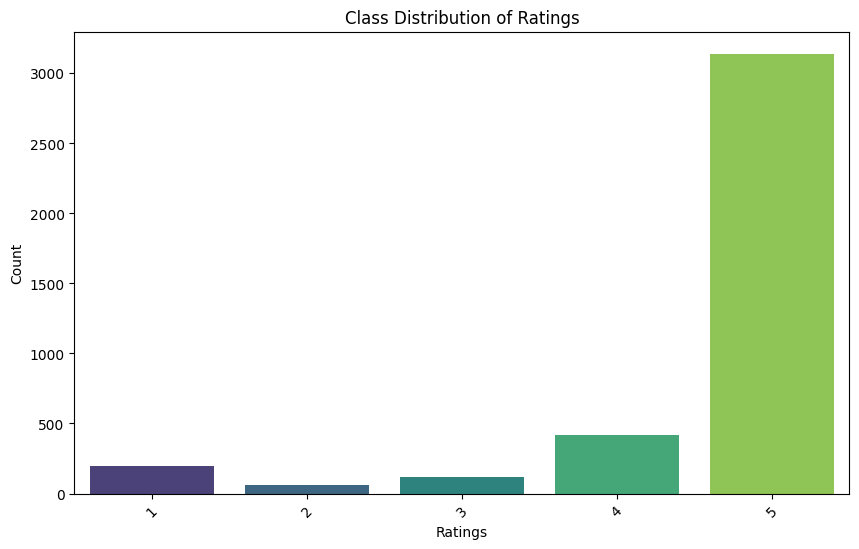

In [11]:
# 1. Class distribution table
class_distribution = train_df['multi_class_label'].value_counts().reset_index()
class_distribution.columns = ['Rating', 'Count']

df['tokenizedReviews'] = df['cleanedReviews'].apply(lambda x: x.split())
df['tokenLength'] = df['tokenizedReviews'].apply(len)

print("\nClass Distribution Table:")
print(class_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x='Rating', y='Count', data=class_distribution, palette='viridis')
plt.title('Class Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [12]:
# Calculate basic statistics
num_train_samples = train_df.shape[0]
num_val_samples = val_df.shape[0]
num_test_samples = test_df.shape[0]

token_stats = {
    'Minimum Tokens': df['tokenLength'].min(),
    'Average Tokens': df['tokenLength'].mean(),
    'Maximum Tokens': df['tokenLength'].max(),
}

In [13]:
# Count reviews in each class
train_class_counts = train_df['multi_class_label'].value_counts().sort_index()
val_class_counts = val_df['multi_class_label'].value_counts().sort_index()
test_class_counts = test_df['multi_class_label'].value_counts().sort_index()

# Summary table
summary_data = {
    'Dataset': ['Training', 'Validation', 'Testing'],
    'Number of Samples': [num_train_samples, num_val_samples, num_test_samples],
}

In [14]:
for i in range(5):
    summary_data[f'Class {i+1} Count'] = [
        train_class_counts.get(i, 0),
        val_class_counts.get(i, 0),
        test_class_counts.get(i, 0)
    ]

summary_df = pd.DataFrame(summary_data)

# Display summary statistics
print("Token Statistics:")
for stat, value in token_stats.items():
    print(f"{stat}: {value}")

print("\nSummary Statistics:")
print(summary_df)

Token Statistics:
Minimum Tokens: 0
Average Tokens: 25.383926754832146
Maximum Tokens: 781

Summary Statistics:
      Dataset  Number of Samples  Class 1 Count  Class 2 Count  Class 3 Count  \
0    Training               3932              0            194             60   
1  Validation                491              0             23             15   
2     Testing                492              0             27              5   

   Class 4 Count  Class 5 Count  
0            117            421  
1             12             56  
2             13             50  


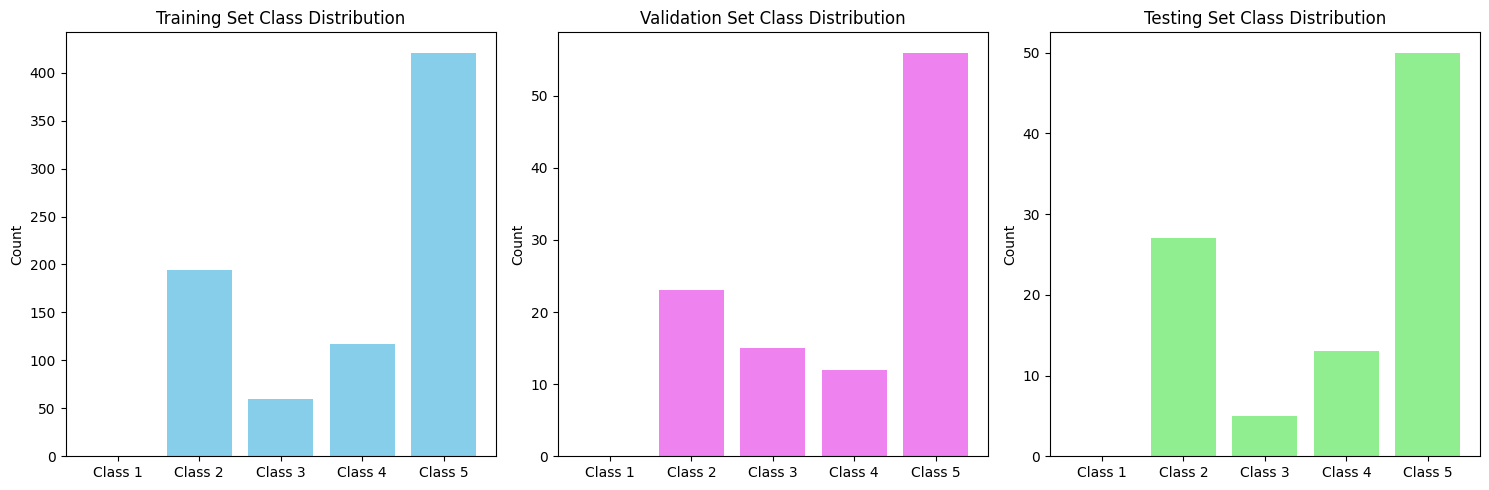

In [15]:
# Plotting the distribution of classes
labels = [f'Class {i+1}' for i in range(5)]
train_counts = [train_class_counts.get(i, 0) for i in range(5)]
val_counts = [val_class_counts.get(i, 0) for i in range(5)]
test_counts = [test_class_counts.get(i, 0) for i in range(5)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].bar(labels, train_counts, color='skyblue')
axes[0].set_title('Training Set Class Distribution')
axes[0].set_ylabel('Count')

axes[1].bar(labels, val_counts, color='violet')
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_ylabel('Count')

axes[2].bar(labels, test_counts, color='lightgreen')
axes[2].set_title('Testing Set Class Distribution')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [16]:
# Class proportions
class_proportions_train = train_class_counts / num_train_samples
class_proportions_val = val_class_counts / num_val_samples
class_proportions_test = test_class_counts / num_test_samples

print("\nClass Proportions:")
print("\nTrain Data:")
print(class_proportions_train)
print("\nVal Data:")
print(class_proportions_val)
print("\nTest Data:")
print(class_proportions_test)


Class Proportions:

Train Data:
multi_class_label
1    0.049339
2    0.015259
3    0.029756
4    0.107070
5    0.798576
Name: count, dtype: float64

Val Data:
multi_class_label
1    0.046843
2    0.030550
3    0.024440
4    0.114053
5    0.784114
Name: count, dtype: float64

Test Data:
multi_class_label
1    0.054878
2    0.010163
3    0.026423
4    0.101626
5    0.806911
Name: count, dtype: float64


In [17]:
# Mean and median class counts
mean_class_counts = {
    'Mean Class Count': [train_class_counts.mean(), val_class_counts.mean(), test_class_counts.mean()],
    'Median Class Count': [train_class_counts.median(), val_class_counts.median(), test_class_counts.median()]
}

mean_median_df = pd.DataFrame(mean_class_counts, index=['Training', 'Validation', 'Testing'])

print("\nMean and Median Class Counts:")
print(mean_median_df)


Mean and Median Class Counts:
            Mean Class Count  Median Class Count
Training               786.4               194.0
Validation              98.2                23.0
Testing                 98.4                27.0


In [18]:
# Standard deviation of class counts
std_class_counts = {
    'Standard Deviation': [train_class_counts.std(), val_class_counts.std(), test_class_counts.std()]
}
std_df = pd.DataFrame(std_class_counts, index=['Training', 'Validation', 'Testing'])

print("\nStandard Deviation of Class Counts:")
print(std_df)


Standard Deviation of Class Counts:
            Standard Deviation
Training           1322.841752
Validation          161.278331
Testing             167.793921


In [19]:
# Grouping multi_class_label and calculate token stats
df['tokenLength'] = df['tokenizedReviews'].apply(len)
train_df['tokenLength'] = df['tokenLength'][:len(y_train)].reset_index(drop=True)
token_stats_per_class = train_df.groupby('multi_class_label')['tokenLength'].agg(['min', 'mean', 'max'])

print("\nToken Statistics Per Class (Training Set):")
print(token_stats_per_class)


Token Statistics Per Class (Training Set):
                   min       mean  max
multi_class_label                     
1                    3  23.963918  141
2                    9  22.916667   86
3                    5  23.589744  139
4                    3  25.681710  544
5                    0  25.011465  400


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


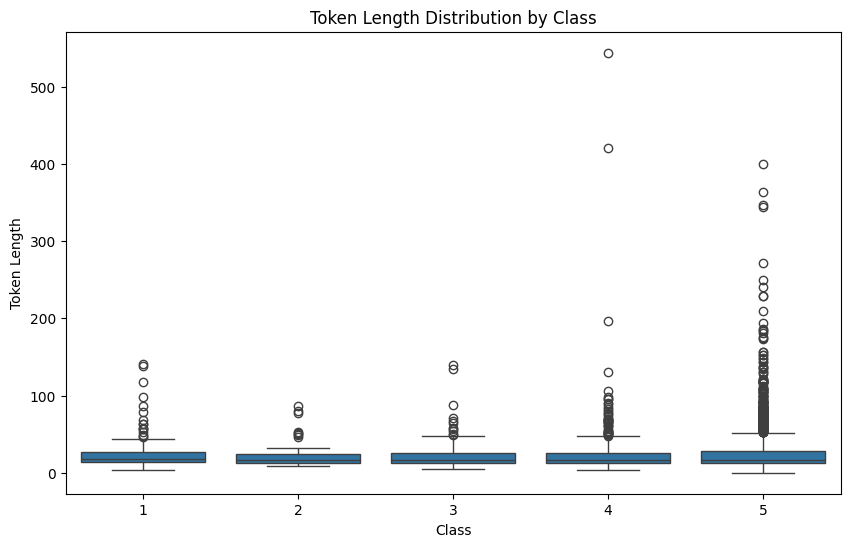

In [20]:
# Visualization of token lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x='multi_class_label', y='tokenLength', data=train_df)
plt.title('Token Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Token Length')
plt.show()

*2. Representation of Texts: word vectors*

2.1.Count-based word vectors with co-occurrence matrix [1]

In [21]:
#1.a.Create vocab,
def get_vocab(corpus):
    stop_words = set(stopwords.words('english'))
    vocab = set()

    for review in corpus:
        if isinstance(review, str):
            cleanedReview = clean_review(review)
            words = cleanedReview.split()
            vocab.update(words)

    return sorted(vocab)

corpus = df['reviewText'].tolist()
distinct_words = get_vocab(corpus)

print(f"Number of distinct words: {len(distinct_words)}")
print("Distinct words:", distinct_words[:10])

Number of distinct words: 9697
Distinct words: ['aac', 'aas', 'aba', 'abdroid', 'abilities', 'ability', 'able', 'aboutgood', 'abouti', 'abouttherehere']


In [22]:
#1b. Compute the co varience matrix
def compute_co_occurrence_matrix(corpus, window_size=4):
    corpus_words = get_vocab(corpus)
    word2index = {word: index for index, word in enumerate(corpus_words)}
    vocab_size = len(corpus_words)
    M = np.zeros((vocab_size, vocab_size), dtype=int)

    for review in corpus:
        if isinstance(review, str):
            cleanedReview = clean_review(review)
            words = cleanedReview.split()
            for i, word in enumerate(words):
                if word in word2index:
                    center_index = word2index[word]
                    start_index = max(0, i - window_size)
                    end_index = min(len(words), i + window_size + 1)

                    for j in range(start_index, end_index):
                        if j != i:
                            neighbor_word = words[j]
                            if neighbor_word in word2index:
                                neighbor_index = word2index[neighbor_word]
                                M[center_index][neighbor_index] += 1

    return M, word2index

corpus = df['reviewText'].tolist()
co_occurrence_matrix, word_index = compute_co_occurrence_matrix(corpus)

print("Co-occurrence matrix shape:", co_occurrence_matrix.shape)
print("Word to index mapping:", {k: v for k, v in list(word_index.items())[:10]})

Co-occurrence matrix shape: (9697, 9697)
Word to index mapping: {'aac': 0, 'aas': 1, 'aba': 2, 'abdroid': 3, 'abilities': 4, 'ability': 5, 'able': 6, 'aboutgood': 7, 'abouti': 8, 'abouttherehere': 9}


In [23]:
#Best value for k [3]
import math
k = int(math.sqrt(len(corpus)))
print(f"Estimated k: {k}")

Estimated k: 70


In [24]:
#1c.Function for dimensionality reduction using SVD, [2]
def reduce_to_k_dim(M, k):
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=42)
    M_reduced = svd.fit_transform(M)
    return M_reduced

k = 70
M_reduced = reduce_to_k_dim(co_occurrence_matrix, k)

print("Reduced matrix shape:", M_reduced.shape)

Reduced matrix shape: (9697, 70)


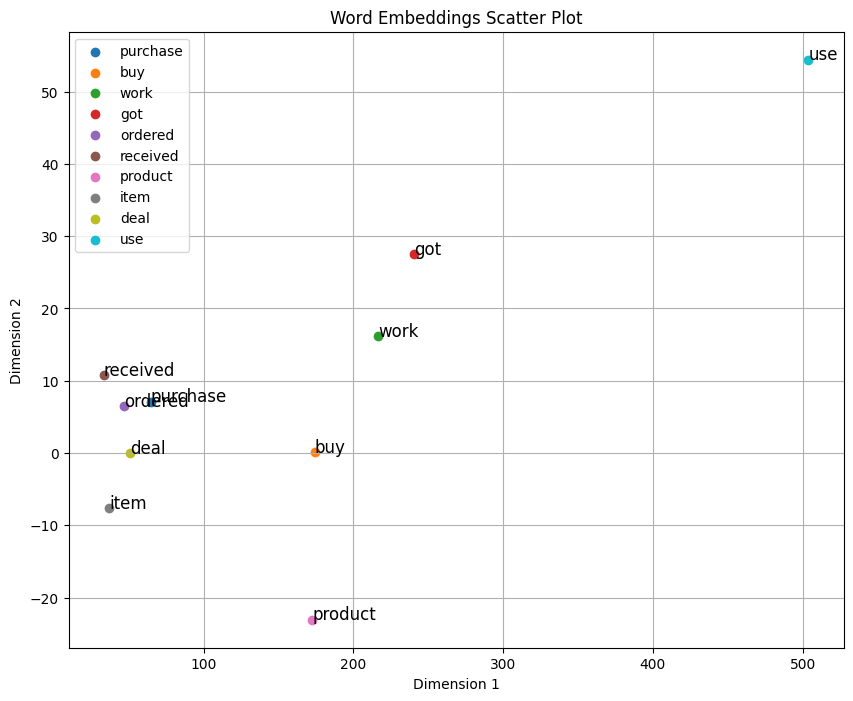

In [25]:
#1d.Plot for the word embeddings
def plot_embeddings(M_reduced, word2index, words_to_plot):
    plt.figure(figsize=(10, 8))

    for word in words_to_plot:
        if word in word2index:
            index = word2index[word]
            plt.scatter(M_reduced[index, 0], M_reduced[index, 1], label=word)
            plt.annotate(word, (M_reduced[index, 0], M_reduced[index, 1]), fontsize=12)

    plt.title('Word Embeddings Scatter Plot')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid()
    plt.show()

words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']
plot_embeddings(M_reduced, word_index, words_to_plot)


2.2 Prediction-based word vectors from Glove

In [26]:
#2a.load_embedding_model()
def load_embedding_model():
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [27]:
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [28]:
#2b.get_matrix_of_vectors
def get_matrix_of_vectors(wv_from_bin, required_words):
    words = list(wv_from_bin.index_to_key)
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]

    word2ind = {}
    M = []
    curInd = 0

    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue

    for w in required_words:
        if w in word2ind:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue

    M = np.stack(M)

    return M, word2ind

required_words = ['purchase', 'buy', 'work', 'got', 'ordered',
                  'received', 'product', 'item', 'deal', 'use']
M, word2ind = get_matrix_of_vectors(wv_from_bin, required_words)


In [29]:
#2c.Reduce the dimension
M_reduced = reduce_to_k_dim(M, 2)
print(f"Reduced matrix shape: {M_reduced.shape}")

Reduced matrix shape: (10010, 2)


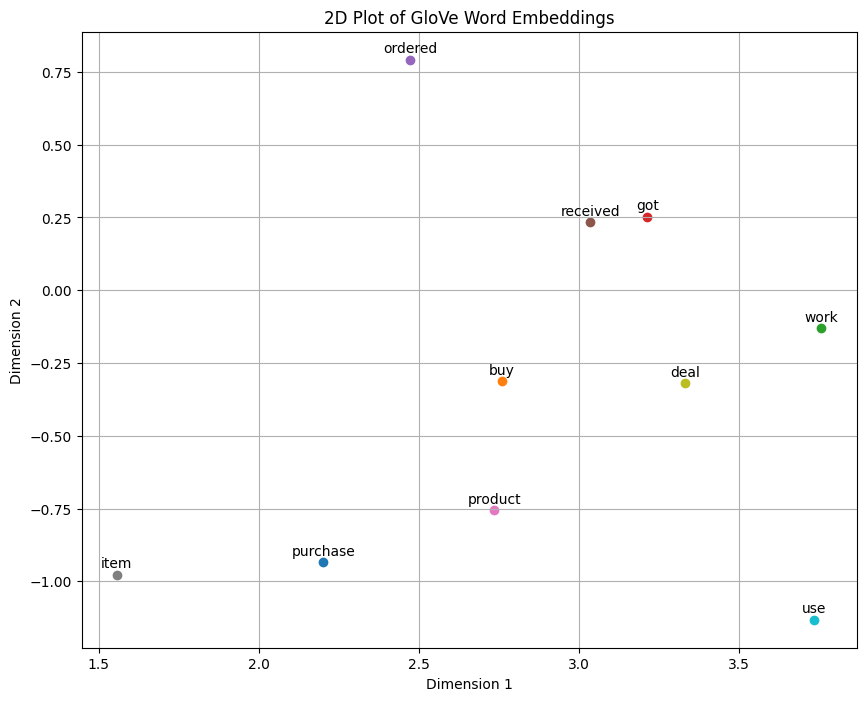

In [30]:
#2d. Visualization
def plot_embeddings(M_reduced, word2index, words_to_plot):
    plt.figure(figsize=(10, 8))
    for word in words_to_plot:
        if word in word2index:
            index = word2index[word]
            plt.scatter(M_reduced[index, 0], M_reduced[index, 1])
            plt.annotate(word, xy=(M_reduced[index, 0], M_reduced[index, 1]), textcoords="offset points", xytext=(0, 5), ha='center')
    plt.title("2D Plot of GloVe Word Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid()
    plt.show()

words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']

plot_embeddings(M_reduced, word2ind, words_to_plot)

 **Discussion: Compare the differences of the plot in 1)d and 2)d, provide some analysis, and
describe your findings.**

*Ans:*   1d. Word Embedding (Word2Vec),  might have the groups closer together if they frequently occur in the same local context. But 2d. The GloVe would likely provide clearer separation between these groups [4], as GloVe model,
creates word vectors such that semantic relationships between
words can be captured as linear relationships in a vector space.


**Task 2: Sentiment Classification Algorithms**

*3. Perform sentiment analysis with classification*

3.1. Review embeddings

In [31]:
k = 128
M_reduced = reduce_to_k_dim(M, k)


In [32]:
#3.1. Review Embeddings
def get_review_embeddings(reviews, word2index, M_reduced):
    review_embeddings = []

    for review in reviews:
        cleaned_review = clean_review(review)
        words = cleaned_review.split()
        embeddings = []

        for word in words:
            if word in word2index:
                index = word2index[word]
                embeddings.append(M_reduced[index])

        if embeddings:
            avg_embedding = np.mean(embeddings, axis=0)
        else:
            avg_embedding = np.zeros(M_reduced.shape[1])

        review_embeddings.append(avg_embedding)

    return np.array(review_embeddings)

reviews = df['reviewText'].tolist()
review_embeddings = get_review_embeddings(reviews, word_index, co_occurrence_matrix)


3.2.Models

In [33]:
# a. Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

X_train_embeddings = get_review_embeddings(X_train.tolist(), word_index, M_reduced)
X_val_embeddings = get_review_embeddings(X_val.tolist(), word_index, M_reduced)

log_reg_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
log_reg_model.fit(X_train_embeddings, y_train)

y_val_pred_lr = log_reg_model.predict(X_val_embeddings)
y_val_prob_lr = log_reg_model.predict_proba(X_val_embeddings)

In [34]:
#Neural Network Model
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

sgd_optimizer = SGD(learning_rate=0.01)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

model = keras.Sequential([
    layers.Input(shape=(X_train_tfidf.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer=sgd_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(X_train_tfidf.toarray(), y_train, epochs=50, batch_size=32,
                    validation_data=(X_val_tfidf.toarray(), y_val),
                    class_weight=class_weights, callbacks=[early_stopping, lr_reduction])

y_val_pred_classes = np.argmax(model.predict(X_val_tfidf.toarray()), axis=1)
y_test_pred_classes = np.argmax(model.predict(X_test_tfidf.toarray()), axis=1)


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7231 - loss: 2.5356 - val_accuracy: 0.7841 - val_loss: 1.2703 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6789 - loss: 1.9710 - val_accuracy: 0.7841 - val_loss: 1.1805 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7770 - loss: 1.7388 - val_accuracy: 0.7841 - val_loss: 1.2319 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7037 - loss: 1.7953 - val_accuracy: 0.7841 - val_loss: 1.1926 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8023 - loss: 1.6347 - val_accuracy: 0.7841 - val_loss: 1.2246 - learning_rate: 0.0020
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


3.3 Model Evaluation

In [35]:
#3.3. Evaluation of Logistic Regression
accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
precision_lr = classification_report(y_val, y_val_pred_lr, output_dict=True)["weighted avg"]["precision"]
recall_lr = classification_report(y_val, y_val_pred_lr, output_dict=True)["weighted avg"]["recall"]
f1_score_lr = classification_report(y_val, y_val_pred_lr, output_dict=True)["weighted avg"]["f1-score"]
auc_lr = roc_auc_score(y_val, y_val_prob_lr, multi_class='ovr')

print("Logistic Regression Performance:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1-Score:", f1_score_lr)
print("AUC:", auc_lr)


Logistic Regression Performance:
Accuracy: 0.7759674134419552
Precision: 0.6312199937454519
Recall: 0.7759674134419552
F1-Score: 0.6925719141623903
AUC: 0.7645451100879995


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [36]:
#3.3. Evaluation of Neural Network Model
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred_classes))
val_loss, val_accuracy = model.evaluate(X_val_tfidf.toarray(), y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("Test Classification Report:\n", classification_report(y_test, y_test_pred_classes))
test_loss, test_accuracy = model.evaluate(X_test_tfidf.toarray(), y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_classes))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        56
           5       0.78      1.00      0.88       385

    accuracy                           0.78       491
   macro avg       0.16      0.20      0.18       491
weighted avg       0.61      0.78      0.69       491

Validation Accuracy: 0.7841
Test Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        50
           5       0.81      1.00      0.89       397

    accuracy                           0.81       492
   macro avg       0.16      0.20      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.8069
Confusion Matrix:
 [[  0   0   0   0  27]
 [  0   0   0   0   5]
 [  0   0   0   0  13]
 [  0   0   0   0  50]
 [  0   0   0   0 397]]


**3.3.b Discussion to compare the performance of those two models**

*ANS:*
1. Logistic Regression:
Performance Metrics:

*  Accuracy: 0.776,
* Precision: 0.631,
* Recall: 0.776,
* F1-Score: 0.693,
* AUC: 0.765 List item

In terms of total accuracy, logistic regression performed reasonably well.   The model can accurately detect a significant amount of positive samples, but it has trouble with false positives, according to the precision and F1-score[5]. This suggests that the model may have trouble differentiating across classes, especially when there is an imbalance in the classes.

2. Neural Network:
Performance Metrics:


*   Validation Accuracy: 0.784
*   Test Accuracy: 0.807
* Validation Report:
Class 1-4 had 0.00 precision and recall, indicating no correct predictions.
Class 5 showed strong performance with precision: 0.78 and recall: 1.00.
* Test Report:
Similar to validation, classes 1-4 had 0.00 metrics.
Class 5 maintained good performance with precision: 0.81 and recall: 1.00.

While the neural network performed better than logistic regression in terms of accuracy on the test set, it showed an identifiable gap in terms of class 1-4 prediction. Samples classified as class 5 by the model appear to be biased[5], which results in poor performance on imbalanced classes. The difficulty of imbalanced data is highlighted by the confusion matrix, which unequivocally demonstrates that the model failed to forecast any of the samples from classes 1-4.









**Comparative Analysis :**


*   *Accuracy:* The neural network outperformed the other model by a little margin in terms of accuracy.
*   *Class Imbalance:* While the neural network was significantly biased towards class 5, logistic regression offered a more balanced outcome across classes. This suggests that in situations where there is a class imbalance, logistic regression might be more reliable.
* *Complexity and Training:* Overfitting may result from a neural network's complexity, particularly when there is insufficient data for a particular class. Because it is a simpler model, logistic regression performed better and did not exhibit this kind of bias.

**Conclusion:**

In summary, the neural network demonstrated improved accuracy, but it struggled to generalize to all classes, especially those that were underrepresented. In the case of class imbalance, logistic regression offered a more balanced perspective, which made it a more dependable choice in such an sentimental analysis task. Subsequent actions could include investigating methods to enhance predictions across all classes in the neural network model, such as the oversampling the minority classes, experimenting with other configurations, or using ensemble approaches.

*Reference:*


[1]   Manning, C. D., & Shapire, R. E. (n.d.). Exploring word vectors. Stanford University. https://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html

[2]   Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Griffiths, D. J., ... & VanderPlas, J. (2011). Truncated SVD. In Scikit-learn (0.24.2). https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

[3] Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning (Version 1.0). Springer. https://web.stanford.edu/~hastie/ElemStatLearn/

[4] GloVe. (n.d.). GloVe: Global Vectors for Word Representation. Stanford NLP Group. Retrieved October 2, 2024, from https://nlp.stanford.edu/projects/glove/

[5] Ng, A. (2021). Machine learning [Online course]. Coursera. https://www.coursera.org/learn/machine-learning







**TASK 03: Self Reflection**

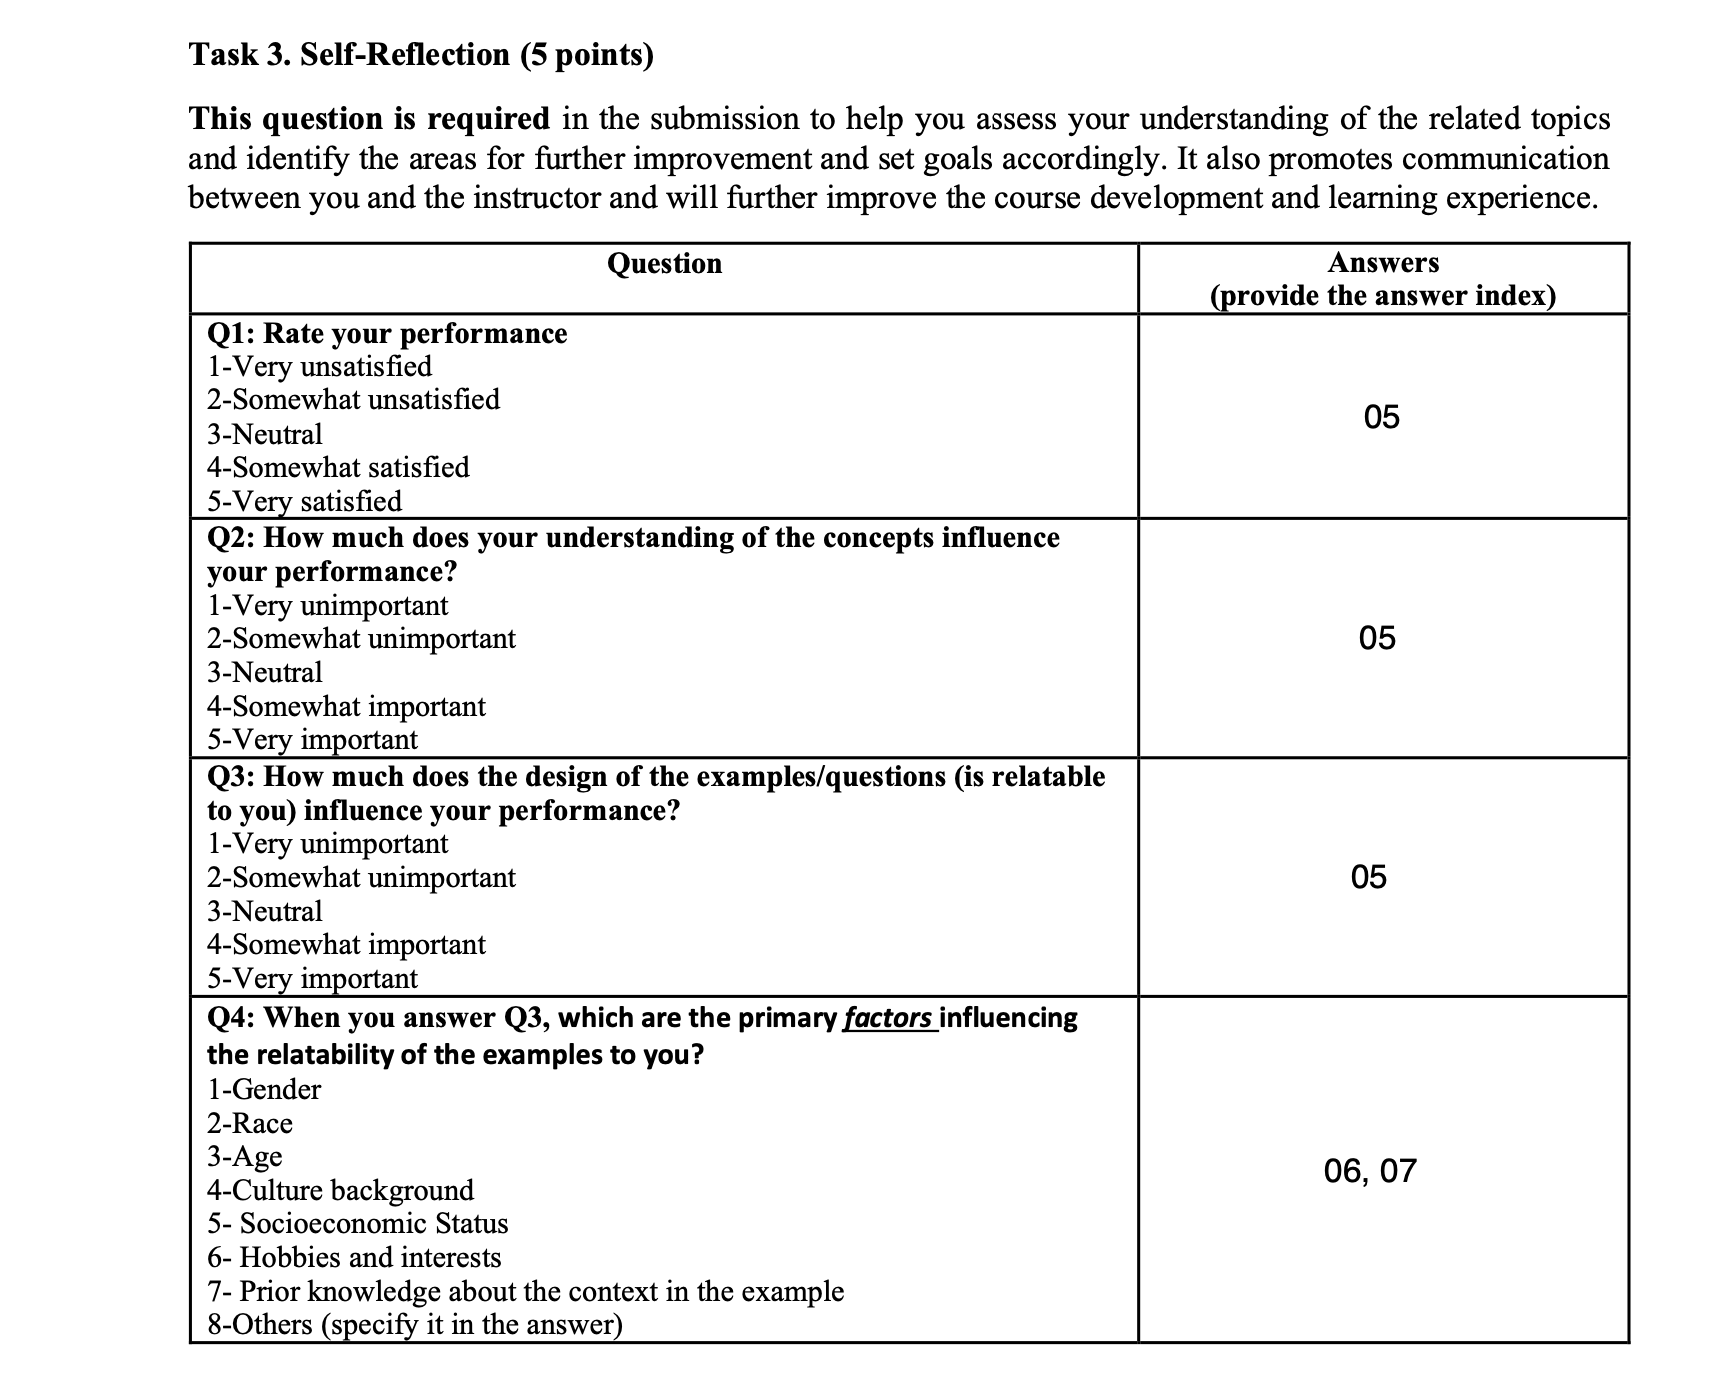